![logo](../../picture/license_header_logo.png)
> **Copyright &copy; 2020 - 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). <br>
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# 05 - Time Series Classification Using Deep Learning

Revised by: [Kian Yang Lee](https://github.com/KianYang-Lee) - kianyang.lee@certifai.ai


## Notebook Description

This tutorial will showcase how to perform time series classifiation using long short-term memory network, a variation of deep learning model. PyTorch deep learning framework is used for this notebook. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Prepare dataset to be feed into deep learning model
2. Build and apply LSTM model 
3. Perform classification tasks on time series data

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics](#analytics)
4. [Model Development](#model-dev) 
5. [Evaluation](#evaluation)
6. [Exercise](#exercise)
7. [Reference](#reference)
8. [Bonus](#bonus)



## <a name="configuration">Notebook Configurations</a>
Following are the modules that will be used for this tutorial. This notebook will heavily use `PyTorch` as they provide great APIs when for building deep learning models. You can find out more about them [here](https://pytorch.org/).

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import sys
from torch.utils.data import Dataset, DataLoader, TensorDataset, IterableDataset
import torch
from torch import nn, optim
import torch.nn.functional as F

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# reproducibility
seed = 38
np.random.seed(seed)
torch.manual_seed(seed)

## <a name="dataset">Dataset</a>
The dataset to be used is the NASA Turbofan dataset. You can read more about the dataset [here](https://www.kaggle.com/c/predictive-maintenance)

The dataset consists of different multivariate time-series. These different time-series refer to different engines. The sampling of the time series is 1 point per engine cycle.

Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to
estimate when maintenance should be performed. Predictive maintenance can be modeled in several ways,
1. Predict the Remaining Useful Life (RUL), or Time to Failure (TTF)
2. Predict if the asset will fail by given a certain time frame
3. Predict critical level of the asset by give a certain time frame

For this example, we will be using the 2nd modeling strategy. We are going to predict weather the asset is going to fail. 

The target variable to be used is "Label1". It consist of 0 and 1. 0 means the assets is working fine and 1 means it require maintenance.

In [2]:
# importing dataset
df_train = pd.read_csv("../../datasets/predictive_maintenance/train.csv")
df_test = pd.read_csv("../../datasets/predictive_maintenance/test.csv")

## <a name="analytics">Basic Analytics</a>
Let's do some basic analytics and see what nugget can we find out of the training dataset! Let first find out the number of rows and columns of the training dataset.

**Note: Since we are not supposed to know any information about the test dataset, we will not perform any analytics on it.**

In [3]:
# inspect first 5 rows of training data
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.459770,0.166667,0,0,0.183735,0.406802,0.309757,0,1,0.726248,0.242424,0.109755,0,0.369048,0.633262,0.205882,0.199608,0.363986,0,0.333333,0,0,0.713178,0.724662,0.00000,191,0,0
1,1,2,0.609195,0.250000,0,0,0.283133,0.453019,0.352633,0,1,0.628019,0.212121,0.100242,0,0.380952,0.765458,0.279412,0.162813,0.411312,0,0.333333,0,0,0.666667,0.731014,0.00277,190,0,0
2,1,3,0.252874,0.750000,0,0,0.343373,0.369523,0.370527,0,1,0.710145,0.272727,0.140043,0,0.250000,0.795309,0.220588,0.171793,0.357445,0,0.166667,0,0,0.627907,0.621375,0.00554,189,0,0
3,1,4,0.540230,0.500000,0,0,0.343373,0.256159,0.331195,0,1,0.740741,0.318182,0.124518,0,0.166667,0.889126,0.294118,0.174889,0.166603,0,0.333333,0,0,0.573643,0.662386,0.00831,188,0,0
4,1,5,0.390805,0.333333,0,0,0.349398,0.257467,0.404625,0,1,0.668277,0.242424,0.149960,0,0.255952,0.746269,0.235294,0.174734,0.402078,0,0.416667,0,0,0.589147,0.704502,0.01108,187,0,0


One important note is that the target variable needs to have balanced distribution for us to decide which metrics that is suitable to be used for model evaluation. So, we will check for distribution of target variable first.

In [4]:
# compute class distribution
class_distribution = Counter(df_train["label1"])

print('Classes in train dataset:', class_distribution)

Classes in train dataset: Counter({0: 17531, 1: 3100})


The above class distribution shwows that the dataset has imbalance class, with ratio of around 3.5 : 1. Next, we will inspect are there any missing values in the dataset.

In [5]:
# inspect missing values
df_train.isna().sum() # shows that there are no missing values

id            0
cycle         0
setting1      0
setting2      0
setting3      0
s1            0
s2            0
s3            0
s4            0
s5            0
s6            0
s7            0
s8            0
s9            0
s10           0
s11           0
s12           0
s13           0
s14           0
s15           0
s16           0
s17           0
s18           0
s19           0
s20           0
s21           0
cycle_norm    0
RUL           0
label1        0
label2        0
dtype: int64

There appears to be no missing values based on the above display. Currently, the dataset contains a number of features. However, not all features are useful for model building. We will first remove some unnecessary features before we proceed with model building. 

In [6]:
# removing the unnecessary columns
drop_columns_list = ["setting3", "s1", "s5", "s10", "s16", "s18", "s19", "RUL", "label2"]
df_train_cleaned = df_train.drop(drop_columns_list, axis=1)
df_test_cleaned = df_test.drop(drop_columns_list, axis=1)

print(f"The original dataset has {df_train.shape[1]} columns.")
print(f"After removing unnecessary columns, the dataset now has {df_train_cleaned.shape[1]} columns.")

df_train_cleaned.head()

The original dataset has 30 columns.
After removing unnecessary columns, the dataset now has 21 columns.


,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,cycle_norm,label1
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,0.00000,0
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,0.00277,0
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,0.00554,0
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,0.00831,0
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,0.01108,0


We are also interested in the data type of each column when we are building a model. We will analyze the data type of each column.

In [7]:
# check for the data types
df_train_cleaned.dtypes

id              int64
cycle           int64
setting1      float64
setting2      float64
s2            float64
s3            float64
s4            float64
s6              int64
s7            float64
s8            float64
s9            float64
s11           float64
s12           float64
s13           float64
s14           float64
s15           float64
s17           float64
s20           float64
s21           float64
cycle_norm    float64
label1          int64
dtype: object

We can take note of a few things here. First, the 'ID' column should be indicative of which machine that the data is collected, while the 'Cycle' column indicates the time step that the measurement is taken from. The rest all of the variables have values of more or less the same scale, that is within 0 and 1. This could indicate that someone has already performed Min-Max Normalization for us. Nonetheless, we will also perform it later just to be on the safe side. Before we proceed though, we will first separate out the features and labels for later usage.

In [8]:
# separate out features and target variable
y_train = df_train_cleaned['label1']
X_train = df_train_cleaned.drop('label1', axis=1)
y_test = df_test_cleaned['label1']
X_test = df_test_cleaned.drop('label1', axis=1)

print('Shape for y of train dataset: ', y_train.shape)
print('Shape for x of train dataset: ', X_train.shape)
print('Shape for y of test dataset: ', y_test.shape)
print('Shape for x of test dataset: ', X_test.shape)

Shape for y of train dataset:  (20631,)
Shape for x of train dataset:  (20631, 20)
Shape for y of test dataset:  (13096,)
Shape for x of test dataset:  (13096, 20)


We have separated out the features and the label. We also see that we have 20,631 samples for our training data and 13,096 samples for our test data. Next, we will perform feature scaling using min-max normalization.

In [9]:
# data pre-processing : min-max normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## <a name="model-dev">Model Development</a>
After performing some basic analytics on the dataset at hand, we will start to build deep learning model to classify time series for this dataset. We will be guiding you through the process of developing a LSTM model using `PyTorch`.

LSTM is a variant of recurrent neural network (RNN). RNNs have loops in the network that, theoretically, allows for past information to persist. This feature helps to overcome one of the shortcomings of a traditional neural network, where it is ineffective in modeling sequential data.

RNNs have been applied successfully in many tasks involving sequential data, such as language modeling, machine translation, etc. However, there are certain downsides to a vanilla RNN. RNN is notoriously known for its inability to handle long-term dependencies, and result in vanishing gradient issue. This is not a good news for a network that was initially designed to for such task.

Therefore, LSTMs is popularizeed over RNNs in order to more effectively model sequential data. Its combination of forget gate, input gate, memory gate and hidden cell along with other model architecture details enable it to more effectively handle long-term dependencies over RNN. We will be guiding you on how to build a LSTM model in this tutorial.

If you are interested to find out more about LSTM, Colah provides a great explanation of LSTM, which can be found [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

Before we start building the model though, we have to first prepare our data into the format that can be fed into LSTM model.

In [10]:
# convert dtype to np.ndarray and reshaping it to 2D array
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

print(type(X_train_scaled))
print(type(X_test_scaled))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


We should have `np.ndarray` as the data type for both features and labels now. And indeed the above cell output confirms this. Recall that we need to prepare our dataset into format that is suitable for LSTM to be trained on. We will write a helper function to perform this.

In [11]:
def sequencing_data(x_data, y_data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be numpy.
    """
    x, y = [], []

    # Fill the batch with random sequences of data
    for i in range(x_data.shape[0] - sequence_length):

        # copy the sequences of data starting at this index
        x.append(x_data[i:i + sequence_length + 1])
        y.append(y_data[i + sequence_length])
    
    return x, y

# converting data shape and sequence
X_sequence_train, y_sequence_train = sequencing_data(X_train_scaled, y_train, 29)
X_sequence_test, y_sequence_test = sequencing_data(X_test_scaled, y_test, 29)

# sanity check 
print("Total samples for X train: " + str(len(X_sequence_train)))
print("Total samples for y train: " + str(len(y_sequence_train)))
print("Total samples for X test: " + str(len(X_sequence_test)))
print("Total samples for y test: " + str(len(y_sequence_test)))

Total samples for X train: 20602
Total samples for y train: 20602
Total samples for X test: 13067
Total samples for y test: 13067


Let us use write a customized class that inherits `Dataset` class from `PyTorch` to transform our dataset into `Dataset` class. This then allows us to make use of `DataLoader` method of `PyTorch` to load data batch by batch into the model during training process. This is also the typical way of preparing input data in `PyTorch`.

In [12]:
# write a customized Dataset class
class MaintenanceDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

We will also do a sanity check after using Dataset class of PyTorch to ensure that we have prepared our data into the right format before we feed them into the model.

In [13]:
# creating train and test datasets
train_ds = MaintenanceDataset(X_sequence_train, y_sequence_train)
test_ds = MaintenanceDataset(X_sequence_test, y_sequence_test)

# let us print out the first two rows of train dataset and check the shape of dataset too
print(len(train_ds))          # print out number of samples
print(len(train_ds[0]))       # print out the tuple of first sample
print(len(train_ds[0][0]))    # print out number of features/channels
print(len(train_ds[0][0][0])) # print out number of sequence

20602
2
30
20


Next, after preparing it into the right format, we will use DataLoader to transform our data into iterable.

In [14]:
# instantiate DataLoader instance
batch_size = 200
train_loader = DataLoader(dataset=train_ds,
                          batch_size=batch_size,
                          shuffle=False)

test_loader = DataLoader(dataset=test_ds,
                          batch_size=batch_size,
                          shuffle=False)

dataloaders = {'train': train_loader, 'test': test_loader}

Our input data are finally ready. Nevertheless, we still need to define the architecture of our model. The codes below show how we can define a LSTM model for this task.

In [15]:
# defining model architecture
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__() 
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # LSTM receives input in the form of (batch_size, sequence_length, n_features)
        self.linear = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # initiate zeros tensor with (num_layers, batch_size, hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :] # we just using last time step to do prediction
        out = self.linear(out)
        return out

num_layers = 2       # stack 2 RNN together
num_classes = 1
input_size = 20      # since one row has 20 features, we are reading one row at a time
hidden_size = 128 
    
model = LSTM(input_size, hidden_size, num_layers, num_classes)
print("Model architecture is: \n\n")
print(model)

Model architecture is: 


LSTM(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


Next, we will have to configure our hyperparameters before we proceed to model training. Do note that the values shown here are not the only options that you can use. Hyperparameter tuning is a trial-and-error process. You will have to find out for yourself what kind of hyperparameter works best for different datasets and model.

In [16]:
# set hyperparameters for model
epochs = 5
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

Now, we are going to write code to perform model training and validation. For each epoch, we will train our model on training set and validate it on test set. We will have to set our model to `train` model during model training for backpropagation to occur, and set our model to `eval` mode to disable model parameters from updating.

In [17]:
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, (X, y) in enumerate(dataloaders[phase]):
            with torch.set_grad_enabled(phase == 'train'):
                out = model(X)
                loss = criterion(out, y)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
        print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)

Epoch 1/5
TRAIN Loss: 0.31239788825448744
TEST Loss: 0.07645066037148025
Epoch 2/5
TRAIN Loss: 0.15999575623364173
TEST Loss: 0.04655626958642781
Epoch 3/5
TRAIN Loss: 0.1365068609500878
TEST Loss: 0.04325956883612546
Epoch 4/5
TRAIN Loss: 0.11921028146176153
TEST Loss: 0.03838639199649846
Epoch 5/5
TRAIN Loss: 0.10986944579585964
TEST Loss: 0.04330266736282601


Note that we have stored the loss score during model training and validation for each epoch. We will plot a line chart of loss score (y-axis) against number of epochs (x-axis). This plot will help us to check whether the model is converging.

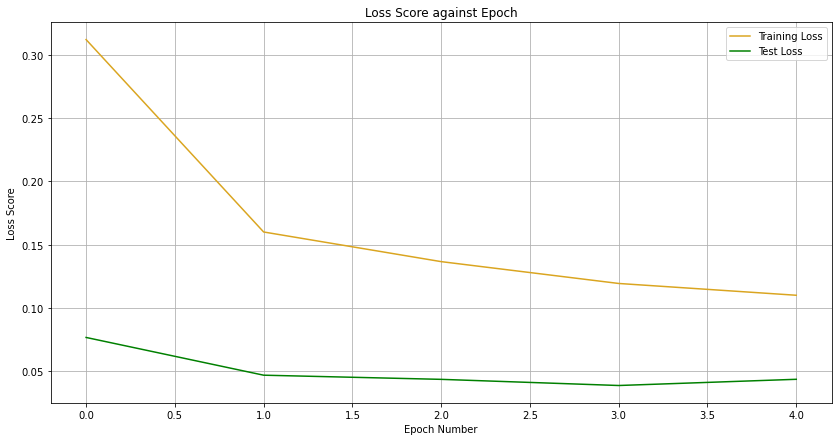

In [18]:
# plot loss score for training and validation loop
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(b=True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")
ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();

We can see from the loss score plot above that the model is converging as there are no sudden upward spikes at the last few epochs. Our model is ready to be tested to check for its performance on unseen data.

## <a name="evaluation">Evaluation</a>
Since this is a classification task, we will be using the following metrics for model evaluation:
* accuracy
* ROC score
* precision
* recall
* f1-score

We will first examine the performance of the model on both the training and test set.

In [19]:
# using threshold to determine which prediction belongs to class 1 or 0
threshold = 0.5

# compute prediction results in the form of numpy ndarray
model.eval()
true_list, preds_list = [], []
for x_test, y_test in DataLoader(dataset=train_ds, batch_size=1, shuffle=False):
    with torch.no_grad():
        true_list.append(y_test.detach().numpy())
        preds = model(x_test)
        preds = torch.sigmoid(preds)
        preds_list.append(preds.detach().numpy())

train_true_np, train_preds_np = np.concatenate(true_list), np.concatenate(preds_list)

# compute evaluation metrics including ROC AUC score, accuracy score, f1-score, precision and recall
print("MODEL PERFORMANCE ON TRAINING DATASET")
print(f'\n\nROC AUC score: {round(roc_auc_score(train_true_np, train_preds_np), 3)}')
print(classification_report(y_true=train_true_np, y_pred=(train_preds_np > threshold).astype(int)))

MODEL PERFORMANCE ON TRAINING DATASET


ROC AUC score: 0.988
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     17502
         1.0       0.85      0.86      0.86      3100

    accuracy                           0.96     20602
   macro avg       0.91      0.92      0.92     20602
weighted avg       0.96      0.96      0.96     20602



In [20]:
# compute prediction results in the form of numpy ndarray
model.eval()
true_list, preds_list = [], []
for x_test, y_test in DataLoader(dataset=test_ds, batch_size=1, shuffle=False):
    with torch.no_grad():
        true_list.append(y_test.detach().numpy())
        preds = model(x_test)
        preds = torch.sigmoid(preds)
        preds_list.append(preds.detach().numpy())

test_true_np, test_preds_np = np.concatenate(true_list), np.concatenate(preds_list)

# compute evaluation metrics including ROC AUC score, accuracy score, f1-score, precision and recall
print("MODEL PERFORMANCE ON TEST DATASET")
print(f'\n\nROC AUC score: {round(roc_auc_score(test_true_np, test_preds_np), 3)}')
print(classification_report(y_true=test_true_np, y_pred=(test_preds_np > threshold).astype(int)))

MODEL PERFORMANCE ON TEST DATASET


ROC AUC score: 0.989
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     12735
         1.0       0.74      0.65      0.70       332

    accuracy                           0.99     13067
   macro avg       0.87      0.82      0.84     13067
weighted avg       0.98      0.99      0.99     13067



Well, our model has shows consistent performance for when tested on both training and test set. This shows that the model does not suffer from overfitting issue. Also, the accuracy score is quite satisfactory and shows no indication of underfitting. Nevertheless, the recall for class 1 is on the down side. This could be due to the imbalance class distribution that was found out earlier. You can try to improve the model performance by tackling the class imbalance issue, for example using undersampling or oversampling techinque. Next, we will be going into the exercise section.

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules which you need had already been imported at this point.

In [21]:
# import modules
### BEGIN SOLUTION


### END SOLUTION

### Dataset
**INSTRUCTIONS**: Please perform binary classification task using the same dataset and features but instead choose the target variable of "label2". Feel free to experiment with other features or use feature engineering techniques.

In [22]:
# import training and test dataset
### BEGIN SOLUTION


### END SOLUTION

### Basic Analytics
**INSTRUCTIONS**: Perform some basic analytics on the dataset by following the guidelines that are provided in each cell.

In [23]:
# compute the number of rows and columns of train data
### BEGIN SOLUTION
df_train_shape = None
df_train_rows = None
df_train_columns = None
### END SOLUTION

print(f"Shape of dataset is: {df_train_shape}")
print("Rows of train data are: " + str(df_train_rows))
print("Columns of train data are: " + str(df_train_columns))

Shape of dataset is: None
Rows of train data are: None
Columns of train data are: None


In [24]:
# inspect first 5 rows of training data
### BEGIN SOLUTION

### END SOLUTION

In [25]:
# compute class distribution
### BEGIN SOLUTION
class_distribution = None
### END SOLUTION

print('Classes in train dataset:', class_distribution)

Classes in train dataset: None


In [26]:
# inspect missing values
### BEGIN SOLUTION

### END SOLUTION

In [27]:
# removing the unnecessary columns
### BEGIN SOLUTION



### END SOLUTION

In [28]:
# check for the data types
### BEGIN SOLUTION

### END SOLUTION

In [29]:
# separate out features and target variable
### BEGIN SOLUTION



### END SOLUTION

In [30]:
# data pre-processing : min-max normalization
### BEGIN SOLUTION


### END SOLUTION

### Model Development
**INSTRUCTIONS**: Prepare the input data and define your own LSTM model. Implement training and validation loop at each epoch.

In [31]:
# write a helper function which slices through the features using the sequence_length parameter and index the labe at the time step
# function should return features in sequence and labels
def sequencing_data(x_data, y_data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be numpy.
    """
    ### BEGIN SOLUTION
    pass
    ### END SOLUTION
    
    return x, y

# calling the helper function and store them in variables
### BEGIN SOLUTION


### END SOLUTION

# sanity check 
### BEGIN SOLUTION
# print("Total samples for X train: " + str(len(X_sequence_train)))
# print("Total samples for y train: " + str(len(y_sequence_train)))
# print("Total samples for X test: " + str(len(X_sequence_test)))
# print("Total samples for y test: " + str(len(y_sequence_test)))
### END SOLUTION

In [32]:
# write a customized Dataset class
class MaintenanceDataset(Dataset):
    """
    Convert input data into torch FloatTensor. 
    Inherit Dataset class. Return length of instance when len method is called and return specific sample
    of data when indexed.
    """    
    ### BEGIN SOLUTION
    pass
    
    
    
    
    
    
    ### END SOLUTION

In [33]:
# instantiate Dataset object
### BEGIN SOLUTION


### END SOLUTION

In [34]:
# instantiate DataLoader object
### BEGIN SOLUTION
batch_size = None










### END SOLUTION

In [35]:
# defining model architecture
class LSTM(nn.Module):
    ### BEGIN SOLUTION
    pass








    ### END SOLUTION

# declaring number of layers, number of classes/output categories, input size and hidden size
### BEGIN SOLUTION




### END SOLUTION

# instantiate LSTM object
### BEGIN SOLUTION
model = None
### END SOLUTION

print("Model architecture is: \n\n")
print(model)

Model architecture is: 


None


In [36]:
# set hyperparameters for model
### BEGIN SOLUTION




### END SOLUTION

In [37]:
# implement model training and validation loop
### BEGIN SOLUTION
























### END SOLUTION

In [38]:
# plot loss score for training and validation loop
### BEGIN SOLUTION












### END SOLUTION

### Evaluation
**INSTRUCTIONS:** Follow the guidelines given in the cells to evaluate performance of model.

In [39]:
# compute prediction results in the form of numpy ndarray and evaluation metrics including accuracy score, f1-score, precision and recall
### BEGIN SOLUTION

















### END SOLUTION

## <a name="reference">Reference</a>:
1. [Deep Learning for tabular data using Pytorch](https://jovian.ai/aakanksha-ns/shelter-outcome)
2. [pytorch custom dataset: DataLoader returns a list of tensors rather than tensor of a list](https://stackoverflow.com/questions/62208904/pytorch-custom-dataset-dataloader-returns-a-list-of-tensors-rather-than-tensor)
3. [Predictive maintenance - NASA Turbofan Dataset](https://www.kaggle.com/c/predictive-maintenance)
4. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## <a name="bonus">Bonus</a>
We can also just load one batch of DataLoader as checking, by converting DataLoader to iterator and calling `next` method

In [40]:
next(iter(train_loader))

[tensor([[[0.0000, 0.0000, 0.4598,  ..., 0.7132, 0.7247, 0.0000],
          [0.0000, 0.0028, 0.6092,  ..., 0.6667, 0.7310, 0.0028],
          [0.0000, 0.0055, 0.2529,  ..., 0.6279, 0.6214, 0.0055],
          ...,
          [0.0000, 0.0748, 0.3621,  ..., 0.6744, 0.5384, 0.0748],
          [0.0000, 0.0776, 0.5690,  ..., 0.6124, 0.6428, 0.0776],
          [0.0000, 0.0803, 0.3736,  ..., 0.7054, 0.7136, 0.0803]],
 
         [[0.0000, 0.0028, 0.6092,  ..., 0.6667, 0.7310, 0.0028],
          [0.0000, 0.0055, 0.2529,  ..., 0.6279, 0.6214, 0.0055],
          [0.0000, 0.0083, 0.5402,  ..., 0.5736, 0.6624, 0.0083],
          ...,
          [0.0000, 0.0776, 0.5690,  ..., 0.6124, 0.6428, 0.0776],
          [0.0000, 0.0803, 0.3736,  ..., 0.7054, 0.7136, 0.0803],
          [0.0000, 0.0831, 0.5805,  ..., 0.6202, 0.6091, 0.0831]],
 
         [[0.0000, 0.0055, 0.2529,  ..., 0.6279, 0.6214, 0.0055],
          [0.0000, 0.0083, 0.5402,  ..., 0.5736, 0.6624, 0.0083],
          [0.0000, 0.0111, 0.3908,  ...,